#**Δ-ML and hML (hierarchical machine learning)**

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/dralgroup/MLinQCbook22-delta/blob/main/delta-ML_hML_colab.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/dralgroup/MLinQCbook22-delta/blob/main/delta-ML_hML_colab.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [ ]:
# download necessary files if not exist
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/R_20.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/E_FCI_20.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/R_451.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/E_FCI_451.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/E_UHF_451.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/itrain.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-delta/main/itest.dat

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Any
from itertools import product
from copy import deepcopy
from abc import abstractmethod, ABC

# define KRR class

In [25]:
class BaseEstimator(ABC):
    def fit(self, X, y): 
        if len(X)[0] != len(y)[0]:
            raise Error('Error, size of X and y is not equal.')
    
    @abstractmethod
    def predict(self, X): pass
    
    @staticmethod
    def mse(y_ref, y_pred) -> float:
        tmp = (y_ref - y_pred) ** 2
        return tmp.sum() / len(tmp)
    
    @abstractmethod
    def set_kw(self, kw: Dict[str, Any]): pass
    

class KRR(BaseEstimator):
    def __init__(self, kernel='Linear', lambda_=0.1, **kw):
        self.kernel = getattr(self, kernel)
        self.params = {'lambda': lambda_, 'sigma': 0.01}
        self.set_kw(kw)
        self.train_x = None
        self.alpha = None
    
    def set_kw(self, kw: Dict[str, Any]):
        for k, v in kw.items():
            self.params[k] = v
    
    def Linear(self, x1, x2):
        return x1 @ x2.T
    
    def Gaussian(self, x1, x2):
        dist = np.sum(x1**2, 1).reshape(-1, 1) \
               + np.sum(x2**2, 1) \
               - 2*np.dot(x1, x2.T)
        return np.exp(-0.5 * dist / (self.params['sigma']**2))
    
    def fit(self, X, y):
        self.train_x = np.asarray(X)
        self.train_y = np.asarray(y).reshape(-1, 1)
        K = self.kernel(self.train_x, self.train_x)
        self.alpha = np.linalg.inv(K + self.params['lambda'] * np.eye(len(self.train_x))) @ self.train_y
    
    def predict(self, X):
        self.pred_x = np.asarray(X)
        K = self.kernel(self.pred_x, self.train_x)
        return K @ self.alpha

# define hyperparameter optimization class

In [26]:
class GridSearch(BaseEstimator):
    def __init__(self, estimator: BaseEstimator, param_grid: Dict[str, Any], cv: int=0) -> None:
        super().__init__()
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.best_param: Dict[str, Any] = dict()
    
    def fit(self, X, y):
        train_idx_list, val_idx_list = self._cv_split(X.shape[0])
        best_mse = 1e50
        # best_model = None
        self.best_param: Dict[str, Any] = dict()
        keys, values = zip(*self.param_grid.items())
        for params_value in product(*values):
            params = dict(zip(keys, params_value))
            self.estimator.set_kw(params)
            mse = self._evaluate_model(self.estimator, X, y, train_idx_list, val_idx_list)
            if mse < best_mse:
                best_mse = mse
                self.best_param = params
                # best_model = deepcopy(self.estimator)
        self.estimator.set_kw(self.best_param)
        self.estimator.fit(X, y)
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def _cv_split(self, cnt: int):
        train_cnt = int(cnt * 0.8); # val_cnt = cnt - train_cnt
        train_idx_list = []; val_idx_list = []
        if self.cv in [0, 1]:
            train_idx_list.append(np.arange(train_cnt))
            val_idx_list.append(np.arange(train_cnt, cnt))
        else:
            batch_num = cnt // self.cv
            for i in range(self.cv):
                flg1, flg2 = batch_num * i, batch_num * (i+1)
                train_idx_list.append(np.r_[np.arange(flg1), np.arange(flg2, cnt)])
                val_idx_list.append(np.arange(flg1, flg2))
        return train_idx_list, val_idx_list
        
    @classmethod
    def _evaluate_model(cls, estimator: BaseEstimator, X, y, train_idx_list: List[Any], val_idx_list: List[Any]):
        mse_list = []
        for train_idx, val_idx in zip(train_idx_list, val_idx_list):
            estimator.fit(X[train_idx], y[train_idx])
            y_pred = estimator.predict(X[val_idx])
            mse = cls.mse(y[val_idx], y_pred)
            mse_list.append(mse)
        return np.array(mse_list).mean()
    
    def set_kw(self, kw: Dict[str, Any]): pass

# load data

In [27]:
x = np.loadtxt('R_451.dat')
yt = np.loadtxt('E_FCI_451.dat')
yb = np.loadtxt('E_UHF_451.dat')
delta_y = yt - yb
train_idx = np.loadtxt('itrain.dat', dtype=np.int64) - 1
train_idx = train_idx[3:]
test_idx = np.loadtxt('itest.dat', dtype=np.int64) - 1

## Fig 1

ML param: {'lambda': 3.7926901907322536e-11, 'sigma': 2.6366508987303554}
∆-ML param: {'lambda': 1.274274985703132e-10, 'sigma': 2.6366508987303554}


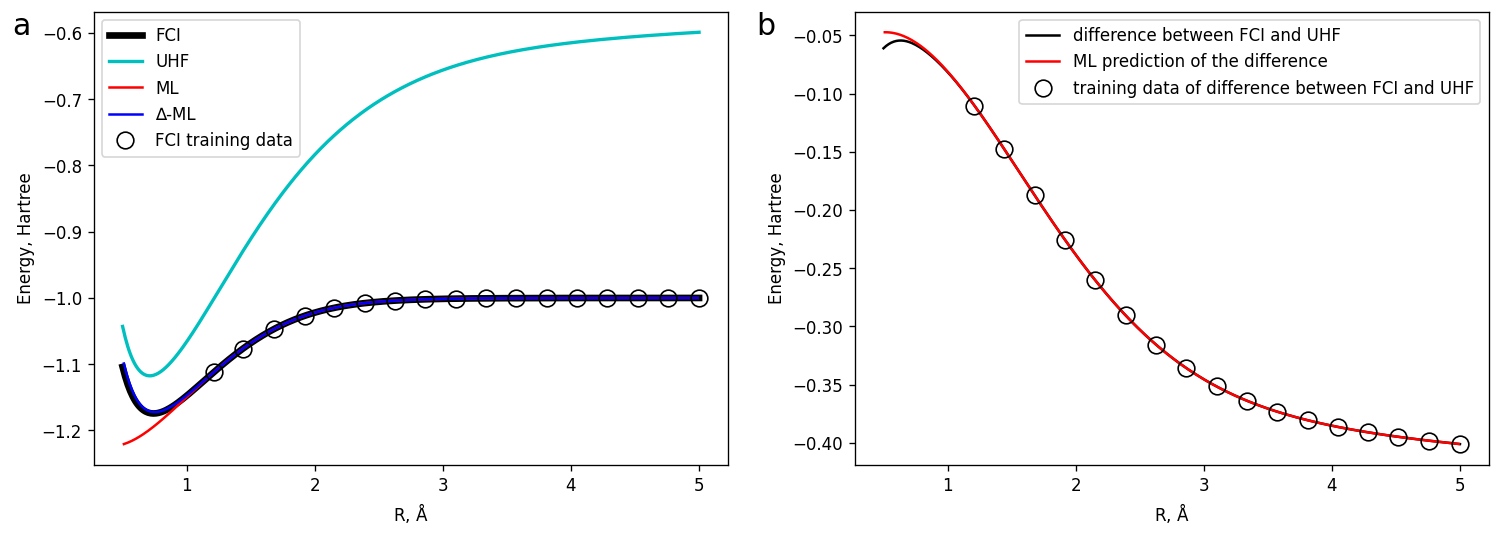

In [28]:
krr = KRR(kernel='Gaussian')
gs = GridSearch(krr, param_grid={'lambda': np.logspace(-12, -2, 20),
                                 'sigma': np.logspace(-10, 8, 20)})
plt.figure(figsize=(15, 5), dpi=120)
plt.subplot(121)
plt.plot(x, yt, 'k', lw=4, label='FCI')
plt.plot(x, yb, 'c', lw=2, label='UHF')
train_x, train_y = x[train_idx], yt[train_idx]
test_x, test_y = x[test_idx], yt[test_idx]
gs.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))
pred_y = gs.predict(test_x.reshape(-1, 1))
plt.plot(test_x, pred_y.ravel(), 'r', label='ML')
print(f'ML param: {gs.best_param}')

train_x, train_y = x[train_idx], delta_y[train_idx]
test_x, test_y = x[test_idx], delta_y[test_idx]
gs.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))
pred_y = gs.predict(test_x.reshape(-1, 1))
plt.plot(test_x, pred_y.ravel() + yb[test_idx], 'b', label='∆-ML')
print(f'∆-ML param: {gs.best_param}')

plt.plot(train_x, yt[train_idx], 'ko', markerfacecolor='none', markersize=10, label='FCI training data')
plt.xlabel('R, $\mathrm{\AA}$'); plt.ylabel('Energy, Hartree')
plt.legend()
plt.text(-0.1, 1.0, 'a', transform=plt.gca().transAxes, fontsize=18, va='top', ha='right')

plt.subplot(122)
plt.plot(x, yt-yb, 'k', label='difference between FCI and UHF')
plt.plot(x[test_idx], pred_y, 'r', label='ML prediction of the difference')
plt.plot(train_x, train_y, 'ko', markerfacecolor='none', markersize=10, label='training data of difference between FCI and UHF')
plt.xlabel('R, $\mathrm{\AA}$'); plt.ylabel('Energy, Hartree')
plt.legend()
plt.text(-0.125, 1.0, 'b', transform=plt.gca().transAxes, fontsize=18, va='top', ha='right')

plt.gcf().savefig('fig1.jpg')

## Case Study 1 & Fig 3

FCI direct learning parameter: {'lambda': 1.623776739188721e-08, 'sigma': 2.6366508987303554}


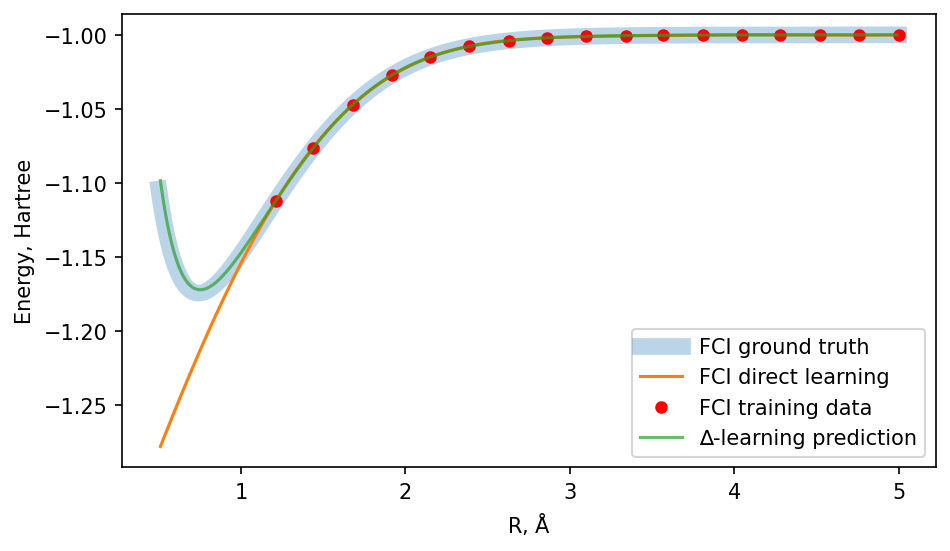

In [29]:
krr = KRR(kernel='Gaussian')
gs = GridSearch(krr, param_grid={'lambda': np.logspace(-12, -2, 20),
                                 'sigma': np.logspace(-10, 8, 20)}, cv=5)
plt.figure(figsize=(7, 4), dpi=150)
plt.plot(x, yt, lw=8, alpha=0.3, label='FCI ground truth')
train_x, train_y = x[train_idx], yt[train_idx]
test_x, test_y = x[test_idx], yt[test_idx]
gs.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))
print(f'FCI direct learning parameter: {gs.best_param}')
pred_y = gs.predict(test_x.reshape(-1, 1))
plt.plot(test_x, pred_y.ravel(), label='FCI direct learning')
plt.plot(train_x, train_y, 'ro', markersize=5, label='FCI training data')
plt.xlabel('R, $\mathrm{\AA}$'); plt.ylabel('Energy, Hartree')

train_x, train_y = x[train_idx], delta_y[train_idx]
test_x, test_y = x[test_idx], delta_y[test_idx]
gs.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))
pred_y = gs.predict(test_x.reshape(-1, 1))
plt.plot(test_x, pred_y.ravel() + yb[test_idx], alpha=0.7, label='∆-learning prediction')
plt.legend()

plt.gcf().savefig('fig3.jpg')

## Case Study 2 & Fig 4

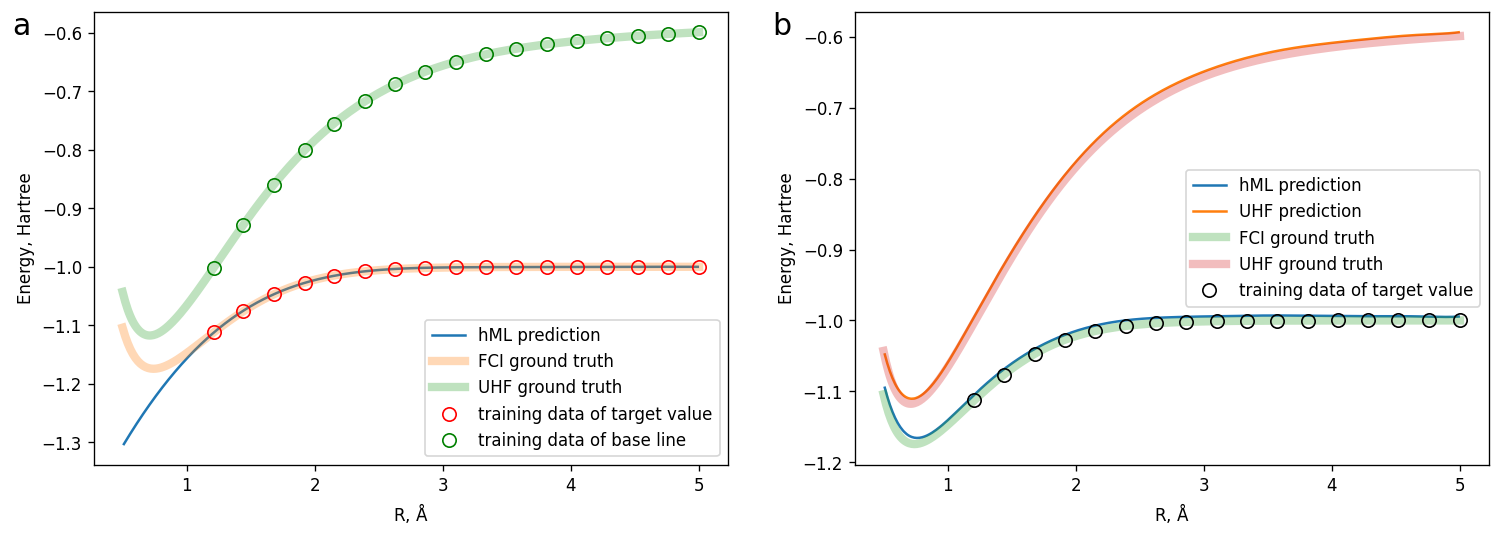

In [30]:
krr = KRR(kernel='Gaussian')
gs = GridSearch(krr, param_grid={'lambda': np.logspace(-12, -2, 20),
                                 'sigma': np.logspace(-10, 8, 20)}, cv=5)
plt.figure(figsize=(15, 5), dpi=120)
plt.subplot(121)
train_x, train_y = x[train_idx], yb[train_idx]
test_x, test_y = x[test_idx], yb[test_idx]
gs.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))
pred_uhf = gs.predict(test_x.reshape(-1, 1))
train_x, train_y = x[train_idx], (yt - yb)[train_idx]
test_x, test_y = x[test_idx], (yt - yb)[test_idx]
gs.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))
pred_delta = gs.predict(test_x.reshape(-1, 1))
pred_hML = pred_uhf + pred_delta

plt.plot(test_x, pred_hML.ravel(), label='hML prediction')
plt.plot(x, yt, alpha=0.3, lw=5, label='FCI ground truth')
plt.plot(x, yb, alpha=0.3, lw=5, label='UHF ground truth')
# plt.plot(x[train_idx], yt[train_idx], 'ro', label='training data')
plt.plot(x[train_idx], yt[train_idx], 'ro', markerfacecolor='none', markersize=8, label='training data of target value')
plt.plot(x[train_idx], yb[train_idx], 'go', markerfacecolor='none', markersize=8, label='training data of base line')
plt.xlabel('R, $\mathrm{\AA}$'); plt.ylabel('Energy, Hartree')
plt.legend()
plt.text(-0.1, 1.0, 'a', transform=plt.gca().transAxes, fontsize=18, va='top', ha='right')

plt.subplot(122)
test_x, test_y = x[test_idx], yb[test_idx]
gs.fit(x.reshape(-1, 1), yb.reshape(-1, 1))
# plt.plot(x, yb, 'co', markerfacecolor='none', markersize=10, label='training data of base line')
pred_uhf = gs.predict(test_x.reshape(-1, 1))
pred_hML = pred_uhf + pred_delta
plt.plot(test_x, pred_hML.ravel(), label='hML prediction')
plt.plot(test_x, pred_uhf.ravel(), label='UHF prediction')
plt.plot(x, yt, lw=5, alpha=0.3, label='FCI ground truth')
plt.plot(x, yb, lw=5, alpha=0.3, label='UHF ground truth')
plt.plot(x[train_idx], yt[train_idx], 'ko', markerfacecolor='none', markersize=8, label='training data of target value')
plt.xlabel('R, $\mathrm{\AA}$'); plt.ylabel('Energy, Hartree')
plt.legend()
plt.text(-0.1, 1.0, 'b', transform=plt.gca().transAxes, fontsize=18, va='top', ha='right')

plt.gcf().savefig('fig4.jpg')